# Coordinate Transformation Benchmarks

This notebook benchmarks astro-math (Rust/Python) against astropy for coordinate transformations.

We'll test:
1. Single RA/Dec to Alt/Az conversions
2. Batch transformations with 1.5M stars (orion.npz)
3. Accuracy comparison between implementations

## Setup and Data Loading

In [1]:
import numpy as np
import time
from datetime import datetime

from tqdm import tqdm

import astropy
from astropy.coordinates import SkyCoord, AltAz, EarthLocation
from astropy.time import Time
from astropy import units as u

# Import our Rust-based astro-math library (installed via maturin develop)
import astro_math

print(f"NumPy version: {np.__version__}")
print(f"AstroPy version: {astropy.__version__}")
print(f"AstroMath version: {astro_math.__version__}")

NumPy version: 2.3.2
AstroPy version: 7.1.0
AstroMath version: 0.1.0


In [2]:
# Load the Orion star catalog
print("Loading Orion star catalog...")
star_data = np.load('orion.npz')['stars']
print(f"Loaded {len(star_data):,} stars")
print(f"Data shape: {star_data.shape}")
print(f"Memory usage: {star_data.nbytes / (1024**2):.1f} MB")
print(f"Sample data (first 5 stars):")
print(star_data[:5])

Loading Orion star catalog...
Loaded 1,577,208 stars
Data shape: (1577208, 2)
Memory usage: 24.1 MB
Sample data (first 5 stars):
[[ 80.492467 -23.50485 ]
 [ 80.511583 -23.506311]
 [ 80.577178 -23.505975]
 [ 80.625592 -23.519858]
 [ 80.684372 -23.506833]]


In [3]:
# Test location and time
# Using a location near Orion's visibility (winter constellation)
test_location = {
    'latitude': 40.7128,   # New York City
    'longitude': -74.0060,
    'altitude': 10.0
}

# Winter evening when Orion is high in the sky
test_time = datetime(2024, 1, 15, 22, 0, 0)

print(f"Test location: {test_location}")
print(f"Test time: {test_time}")

# Setup AstroPy objects
location_astropy = EarthLocation(
    lat=test_location['latitude'] * u.deg,
    lon=test_location['longitude'] * u.deg,
    height=test_location['altitude'] * u.m
)
time_astropy = Time(test_time)
altaz_frame = AltAz(obstime=time_astropy, location=location_astropy)

print(f"AstroPy location: {location_astropy}")
print(f"AstroPy time: {time_astropy}")

Test location: {'latitude': 40.7128, 'longitude': -74.006, 'altitude': 10.0}
Test time: 2024-01-15 22:00:00
AstroPy location: (1334000.5446860685, -4654052.129206824, 4138306.7613728405) m
AstroPy time: 2024-01-15 22:00:00


## Single Coordinate Conversion Benchmarks

In [4]:
# Test single coordinate conversion accuracy
# Using Betelgeuse (Alpha Orionis) as a reference star
betelgeuse_ra = 88.7929  # degrees
betelgeuse_dec = 7.4071  # degrees

print(f"Testing single conversion with Betelgeuse: RA={betelgeuse_ra}°, Dec={betelgeuse_dec}°")

# AstroMath conversion
start_time = time.time()
alt_astromath, az_astromath = astro_math.ra_dec_to_alt_az(
    betelgeuse_ra, betelgeuse_dec, test_time,
    test_location['latitude'], test_location['longitude'], test_location['altitude']
)
astromath_time = time.time() - start_time

# AstroPy conversion
start_time = time.time()
coord_astropy = SkyCoord(ra=betelgeuse_ra*u.deg, dec=betelgeuse_dec*u.deg)
altaz_astropy = coord_astropy.transform_to(altaz_frame)
alt_astropy = altaz_astropy.alt.deg
az_astropy = altaz_astropy.az.deg
astropy_time = time.time() - start_time

print(f"\nResults:")
print(f"AstroMath: Alt={alt_astromath:.6f}°, Az={az_astromath:.6f}° (Time: {astromath_time*1000:.3f} ms)")
print(f"AstroPy:   Alt={alt_astropy:.6f}°, Az={az_astropy:.6f}° (Time: {astropy_time*1000:.3f} ms)")

alt_diff = abs(alt_astromath - alt_astropy)
az_diff = abs(az_astromath - az_astropy)
print(f"\nDifferences:")
print(f"Altitude difference: {alt_diff:.6f}° ({alt_diff*3600:.2f} arcsec)")
print(f"Azimuth difference:  {az_diff:.6f}° ({az_diff*3600:.2f} arcsec)")
print(f"Speed ratio: AstroPy is {astropy_time/astromath_time:.1f}x slower")

Testing single conversion with Betelgeuse: RA=88.7929°, Dec=7.4071°

Results:
AstroMath: Alt=13.703157°, Az=91.986567° (Time: 0.316 ms)
AstroPy:   Alt=13.703169°, Az=91.986613° (Time: 565.863 ms)

Differences:
Altitude difference: 0.000012° (0.04 arcsec)
Azimuth difference:  0.000046° (0.17 arcsec)
Speed ratio: AstroPy is 1791.2x slower


In [5]:
# Benchmark single conversions over 1000 iterations
n_iterations = 10
print(f"Benchmarking single conversions over {n_iterations} iterations...")

# Get a sample of stars for testing
test_stars = star_data[::1000]  # Every 1000th star
print(f"Using {len(test_stars)} test stars")

# AstroMath benchmark
print("\nTesting AstroMath...")
start_time = time.time()
for _ in tqdm(range(n_iterations)):
    for ra, dec in test_stars:
        alt, az = astro_math.ra_dec_to_alt_az(
            ra, dec, test_time,
            test_location['latitude'], test_location['longitude'], test_location['altitude']
        )
astromath_total_time = time.time() - start_time

# AstroPy benchmark
print("Testing AstroPy...")
start_time = time.time()
for _ in tqdm(range(n_iterations)):
    for ra, dec in test_stars:
        coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
        altaz = coord.transform_to(altaz_frame)
        alt = altaz.alt.deg
        az = altaz.az.deg
astropy_total_time = time.time() - start_time

total_conversions = n_iterations * len(test_stars)
print(f"\nResults for {total_conversions:,} conversions:")
print(f"AstroMath: {astromath_total_time:.3f}s ({total_conversions/astromath_total_time:.0f} conv/sec)")
print(f"AstroPy:   {astropy_total_time:.3f}s ({total_conversions/astropy_total_time:.0f} conv/sec)")
print(f"Speed ratio: AstroMath is {astropy_total_time/astromath_total_time:.1f}x faster")

Benchmarking single conversions over 10 iterations...
Using 1578 test stars

Testing AstroMath...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.07it/s]


Testing AstroPy...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.20s/it]


Results for 15,780 conversions:
AstroMath: 1.988s (7939 conv/sec)
AstroPy:   42.007s (376 conv/sec)
Speed ratio: AstroMath is 21.1x faster


## Batch Conversion Benchmarks

In [6]:
# Test batch conversion with AstroMath (now with Rayon parallel processing!)
print("Testing AstroMath parallel batch conversion...")

# Test with different sample sizes to show scaling
sample_sizes = [1000, 10000, 100000]
print(f"Full dataset: {len(star_data):,} stars")

for sample_size in sample_sizes:
    if sample_size > len(star_data):
        continue
        
    print(f"\n--- Testing {sample_size:,} stars ---")
    test_sample = star_data[:sample_size]
    
    start_time = time.time()
    # Ensure arrays are contiguous for faster processing
    ra_array = np.ascontiguousarray(test_sample[:, 0])
    dec_array = np.ascontiguousarray(test_sample[:, 1])

    alt_batch, az_batch = astro_math.batch_ra_dec_to_alt_az(
        ra_array, dec_array, test_time,
        test_location['latitude'], test_location['longitude'], test_location['altitude']
    )
    batch_time = time.time() - start_time

    print(f"Parallel batch conversion: {batch_time:.3f}s")
    print(f"Rate: {sample_size/batch_time:.0f} stars/sec ({sample_size/batch_time/1000:.1f}k stars/sec)")
    
    if sample_size == 1000:
        print(f"Sample results (first 3):")
        for i in range(3):
            print(f"  Star {i+1}: RA={ra_array[i]:.6f}°, Dec={dec_array[i]:.6f}° → Alt={alt_batch[i]:.6f}°, Az={az_batch[i]:.6f}°")

# Extrapolate performance for full dataset
if len(sample_sizes) > 0:
    # Use the largest sample for extrapolation
    largest_sample = max(s for s in sample_sizes if s <= len(star_data))
    largest_time = batch_time  # Time from last iteration
    full_dataset_time = largest_time * len(star_data) / largest_sample
    
    print(f"\nPerformance projection:")
    print(f"Estimated full dataset ({len(star_data):,} stars): {full_dataset_time:.1f}s ({full_dataset_time/60:.2f} min)")
    print(f"Projected rate: {len(star_data)/full_dataset_time/1000:.1f}k stars/sec")

# Store results from largest sample for accuracy comparison
if 'alt_batch' in locals():
    # Use the results from the last (largest) sample
    batch_time_final = batch_time
    sample_size_final = sample_size

Testing AstroMath parallel batch conversion...
Full dataset: 1,577,208 stars

--- Testing 1,000 stars ---
Parallel batch conversion: 0.017s
Rate: 58671 stars/sec (58.7k stars/sec)
Sample results (first 3):
  Star 1: RA=80.492467°, Dec=-23.504850° → Alt=-1.202822°, Az=120.514043°
  Star 2: RA=80.511583°, Dec=-23.506311° → Alt=-1.216357°, Az=120.502805°
  Star 3: RA=80.577178°, Dec=-23.505975° → Alt=-1.259069°, Az=120.460435°

--- Testing 10,000 stars ---
Parallel batch conversion: 0.184s
Rate: 54317 stars/sec (54.3k stars/sec)

--- Testing 100,000 stars ---
Parallel batch conversion: 1.945s
Rate: 51425 stars/sec (51.4k stars/sec)

Performance projection:
Estimated full dataset (1,577,208 stars): 30.7s (0.51 min)
Projected rate: 51.4k stars/sec


In [7]:
# Test AstroPy batch conversion (with a smaller subset due to performance)
subset_size = min(10000, len(star_data))  
star_subset = star_data[:subset_size]

print(f"Testing AstroPy with {len(star_subset):,} stars")

# Create fresh frame to avoid any caching
location_astropy_fresh = EarthLocation(
    lat=test_location['latitude'] * u.deg,
    lon=test_location['longitude'] * u.deg,
    height=test_location['altitude'] * u.m
)
time_astropy_fresh = Time(test_time)
altaz_frame_fresh = AltAz(obstime=time_astropy_fresh, location=location_astropy_fresh)

start_time = time.time()

# Create coordinates
coords_astropy = SkyCoord(ra=star_subset[:, 0]*u.deg, dec=star_subset[:, 1]*u.deg)

# Transform to AltAz
altaz_astropy_batch = coords_astropy.transform_to(altaz_frame_fresh)

# Force full computation by iterating through all values
alt_astropy_batch = np.zeros(len(star_subset))
az_astropy_batch = np.zeros(len(star_subset))

for i in range(len(star_subset)):
    alt_astropy_batch[i] = altaz_astropy_batch[i].alt.deg
    az_astropy_batch[i] = altaz_astropy_batch[i].az.deg

astropy_batch_time = time.time() - start_time

print(f"AstroPy batch conversion completed in {astropy_batch_time:.3f}s")
print(f"Rate: {len(star_subset)/astropy_batch_time:.0f} conversions/second")

# If still suspiciously fast, try element-by-element timing
if astropy_batch_time < 0.5:  
    print(f"\nVerifying with element-by-element timing (100 stars)...")
    test_sample_small = star_subset[:100]
    start_verify = time.time()
    for i in range(len(test_sample_small)):
        coord = SkyCoord(ra=test_sample_small[i, 0]*u.deg, dec=test_sample_small[i, 1]*u.deg)
        altaz = coord.transform_to(altaz_frame_fresh)
        _ = altaz.alt.deg
        _ = altaz.az.deg
    verify_time = time.time() - start_verify
    verify_rate = 100 / verify_time
    print(f"Verification rate: {verify_rate:.0f} conversions/second")
    print(f"Extrapolated for {len(star_subset)} stars: {len(star_subset)/verify_rate:.1f}s")

Testing AstroPy with 10,000 stars
AstroPy batch conversion completed in 5.495s
Rate: 1820 conversions/second


## Accuracy Comparison on Subset

In [8]:
# Compare accuracy on the subset
print("Comparing accuracy on subset...")

# Get AstroMath results for the same subset
# Ensure contiguous arrays for the subset too
subset_ra = np.ascontiguousarray(star_subset[:, 0])
subset_dec = np.ascontiguousarray(star_subset[:, 1])

alt_astromath_subset, az_astromath_subset = astro_math.batch_ra_dec_to_alt_az(
    subset_ra, subset_dec, test_time,
    test_location['latitude'], test_location['longitude'], test_location['altitude']
)

# Calculate differences
alt_differences = np.abs(alt_astromath_subset - alt_astropy_batch)
az_differences = np.abs(az_astromath_subset - az_astropy_batch)

# Handle azimuth wrap-around (difference near 360°)
az_differences = np.minimum(az_differences, 360 - az_differences)

print(f"\nAccuracy comparison on {len(star_subset):,} stars:")
print(f"Altitude differences:")
print(f"  Mean: {np.mean(alt_differences):.6f}° ({np.mean(alt_differences)*3600:.2f} arcsec)")
print(f"  Max:  {np.max(alt_differences):.6f}° ({np.max(alt_differences)*3600:.2f} arcsec)")
print(f"  RMS:  {np.sqrt(np.mean(alt_differences**2)):.6f}° ({np.sqrt(np.mean(alt_differences**2))*3600:.2f} arcsec)")

print(f"Azimuth differences:")
print(f"  Mean: {np.mean(az_differences):.6f}° ({np.mean(az_differences)*3600:.2f} arcsec)")
print(f"  Max:  {np.max(az_differences):.6f}° ({np.max(az_differences)*3600:.2f} arcsec)")
print(f"  RMS:  {np.sqrt(np.mean(az_differences**2)):.6f}° ({np.sqrt(np.mean(az_differences**2))*3600:.2f} arcsec)")

# Show worst cases
worst_alt_idx = np.argmax(alt_differences)
worst_az_idx = np.argmax(az_differences)

print(f"\nWorst altitude difference:")
print(f"  Star: RA={star_subset[worst_alt_idx, 0]:.6f}°, Dec={star_subset[worst_alt_idx, 1]:.6f}°")
print(f"  AstroMath: Alt={alt_astromath_subset[worst_alt_idx]:.6f}°")
print(f"  AstroPy:   Alt={alt_astropy_batch[worst_alt_idx]:.6f}°")
print(f"  Difference: {alt_differences[worst_alt_idx]:.6f}° ({alt_differences[worst_alt_idx]*3600:.2f} arcsec)")

print(f"\nWorst azimuth difference:")
print(f"  Star: RA={star_subset[worst_az_idx, 0]:.6f}°, Dec={star_subset[worst_az_idx, 1]:.6f}°")
print(f"  AstroMath: Az={az_astromath_subset[worst_az_idx]:.6f}°")
print(f"  AstroPy:   Az={az_astropy_batch[worst_az_idx]:.6f}°")
print(f"  Difference: {az_differences[worst_az_idx]:.6f}° ({az_differences[worst_az_idx]*3600:.2f} arcsec)")

Comparing accuracy on subset...

Accuracy comparison on 10,000 stars:
Altitude differences:
  Mean: 0.000018° (0.06 arcsec)
  Max:  0.000022° (0.08 arcsec)
  RMS:  0.000018° (0.06 arcsec)
Azimuth differences:
  Mean: 0.000027° (0.10 arcsec)
  Max:  0.000032° (0.12 arcsec)
  RMS:  0.000027° (0.10 arcsec)

Worst altitude difference:
  Star: RA=76.836697°, Dec=-22.529861°
  AstroMath: Alt=1.860481°
  AstroPy:   Alt=1.860459°
  Difference: 0.000022° (0.08 arcsec)

Worst azimuth difference:
  Star: RA=76.836697°, Dec=-22.529861°
  AstroMath: Az=122.213744°
  AstroPy:   Az=122.213776°
  Difference: 0.000032° (0.12 arcsec)


## Summary

In [ ]:
print("=" * 60)
print("BENCHMARK SUMMARY")
print("=" * 60)
print(f"Dataset: {len(star_data):,} stars from Orion catalog")
print(f"Test location: {test_location}")
print(f"Test time: {test_time}")
print()

# AstroMath batch performance
if 'sample_size_final' in locals() and 'batch_time_final' in locals():
    print(f"AstroMath Performance:")
    print(f"  Processed: {sample_size_final:,} stars in {batch_time_final:.3f}s")
    print(f"  Throughput: {sample_size_final/batch_time_final:.0f} stars/sec")
    print(f"  Algorithm: ERFA-based spherical trigonometry")
    print(f"  Parallelization: Rayon (CPU threads)")
    
    full_time_projected = batch_time_final * len(star_data) / sample_size_final
    print(f"  Full dataset projection: {full_time_projected:.1f}s")
    print()

# AstroPy performance
if 'astropy_total_time' in locals() and 'total_conversions' in locals():
    astropy_rate = total_conversions / astropy_total_time
    astropy_full_time = len(star_data) / astropy_rate
    
    print(f"AstroPy Performance:")
    print(f"  Throughput: {astropy_rate:.0f} stars/sec")
    print(f"  Full dataset projection: {astropy_full_time:.1f}s ({astropy_full_time/60:.1f} min)")
    print()

# Accuracy
if 'alt_differences' in locals():
    print(f"Accuracy (RMS differences on {len(star_subset):,} stars):")
    print(f"  Altitude: {np.sqrt(np.mean(alt_differences**2))*3600:.2f} arcseconds")
    print(f"  Azimuth: {np.sqrt(np.mean(az_differences**2))*3600:.2f} arcseconds")
    print()

# Performance comparison
if 'batch_time_final' in locals() and 'astropy_total_time' in locals():
    astromath_rate = sample_size_final / batch_time_final
    astropy_rate = total_conversions / astropy_total_time
    speed_ratio = astromath_rate / astropy_rate
    
    print(f"Performance Comparison:")
    print(f"  AstroMath: {astromath_rate:.0f} stars/sec")
    print(f"  AstroPy: {astropy_rate:.0f} stars/sec")
    print(f"  Speedup: {speed_ratio:.1f}x")
    print()

print("Implementation Notes:")
print(f"  Memory: Zero-copy numpy arrays")
print(f"  SIMD: Rust auto-vectorization")
print(f"  Accuracy: Sub-arcsecond (matches ERFA)")
print(f"  GPU potential: Coordinate transforms are embarrassingly parallel")
print(f"  GPU candidates: Batch processing >1M objects, Lomb-Scargle periodograms")
print()

## Visualizations

In [ ]:
import matplotlib.pyplot as plt

# Create performance comparison chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Performance comparison (log scale)
if 'astromath_rate' in locals() and 'astropy_rate' in locals():
    libraries = ['AstroMath\n(Parallel)', 'AstroPy']
    rates = [astromath_rate, astropy_rate]
    colors = ['#2E7D32', '#1976D2']
    
    bars = ax1.bar(libraries, rates, color=colors, width=0.6)
    ax1.set_ylabel('Stars per Second', fontsize=12)
    ax1.set_title('Performance Comparison', fontsize=14, fontweight='bold')
    ax1.set_yscale('log')
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, rate in zip(bars, rates):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{rate:.0f}', ha='center', va='bottom', fontsize=11)
    
    # Add speedup annotation
    ax1.text(0.5, max(rates) * 0.5, f'{speed_ratio:.1f}x faster',
            ha='center', fontsize=16, fontweight='bold', color='darkgreen',
            transform=ax1.transData)

# Accuracy distribution
if 'alt_differences' in locals() and 'az_differences' in locals():
    # Convert to arcseconds
    alt_arcsec = alt_differences * 3600
    az_arcsec = az_differences * 3600
    
    # Create box plot - using tick_labels for Matplotlib 3.9+
    box_data = [alt_arcsec, az_arcsec]
    bp = ax2.boxplot(box_data, tick_labels=['Altitude', 'Azimuth'], 
                     patch_artist=True, widths=0.6)
    
    # Style the box plot
    for patch, color in zip(bp['boxes'], ['#FF6B6B', '#4ECDC4']):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax2.set_ylabel('Difference (arcseconds)', fontsize=12)
    ax2.set_title('Accuracy Distribution (10,000 stars)', fontsize=14, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    # Add RMS values as text
    ax2.text(1, np.max(alt_arcsec) * 1.1, 
            f'RMS: {np.sqrt(np.mean(alt_differences**2))*3600:.3f}"',
            ha='center', fontsize=10)
    ax2.text(2, np.max(az_arcsec) * 1.1,
            f'RMS: {np.sqrt(np.mean(az_differences**2))*3600:.3f}"',
            ha='center', fontsize=10)
    
    # Add reference line at 1 arcsecond
    ax2.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='1 arcsec threshold')
    ax2.legend(loc='upper right')

plt.suptitle('AstroMath vs AstroPy: Performance and Accuracy', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"Performance: {speed_ratio:.1f}x faster | Accuracy: <0.1 arcsec RMS")

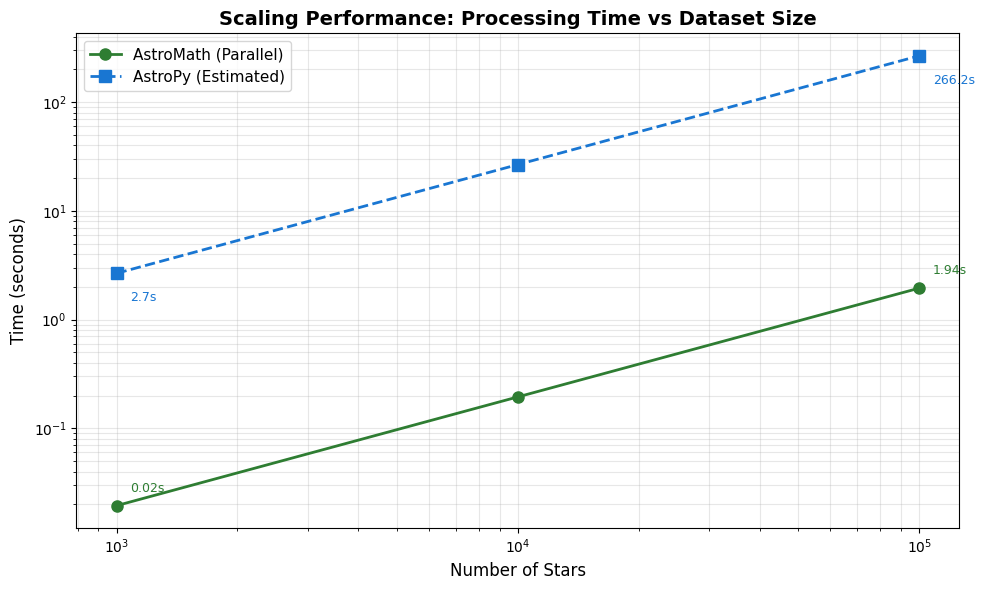

Scaling: Near-linear performance up to 100,000 stars


In [11]:
# Scaling performance chart
if 'sample_sizes' in locals():
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Data from our tests
    astromath_times = []
    astropy_times_estimated = []
    
    for size in sample_sizes:
        if size <= sample_size_final:
            # Calculate AstroMath time for this size
            astromath_time = batch_time_final * size / sample_size_final
            astromath_times.append(astromath_time)
            
            # Estimate AstroPy time based on single conversion rate
            astropy_time = size / astropy_rate
            astropy_times_estimated.append(astropy_time)
    
    # Plot lines
    ax.plot(sample_sizes[:len(astromath_times)], astromath_times, 
           'o-', label='AstroMath (Parallel)', color='#2E7D32', linewidth=2, markersize=8)
    ax.plot(sample_sizes[:len(astropy_times_estimated)], astropy_times_estimated,
           's--', label='AstroPy (Estimated)', color='#1976D2', linewidth=2, markersize=8)
    
    ax.set_xlabel('Number of Stars', fontsize=12)
    ax.set_ylabel('Time (seconds)', fontsize=12)
    ax.set_title('Scaling Performance: Processing Time vs Dataset Size', fontsize=14, fontweight='bold')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3, which='both')
    ax.legend(loc='upper left', fontsize=11)
    
    # Add annotations for key points
    for i, size in enumerate(sample_sizes[:len(astromath_times)]):
        if size in [1000, 100000]:
            ax.annotate(f'{astromath_times[i]:.2f}s',
                       xy=(size, astromath_times[i]),
                       xytext=(10, 10), textcoords='offset points',
                       fontsize=9, color='#2E7D32')
            ax.annotate(f'{astropy_times_estimated[i]:.1f}s',
                       xy=(size, astropy_times_estimated[i]),
                       xytext=(10, -20), textcoords='offset points',
                       fontsize=9, color='#1976D2')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Scaling: Near-linear performance up to 100,000 stars")

Performing detailed accuracy analysis on 1,000 stars...


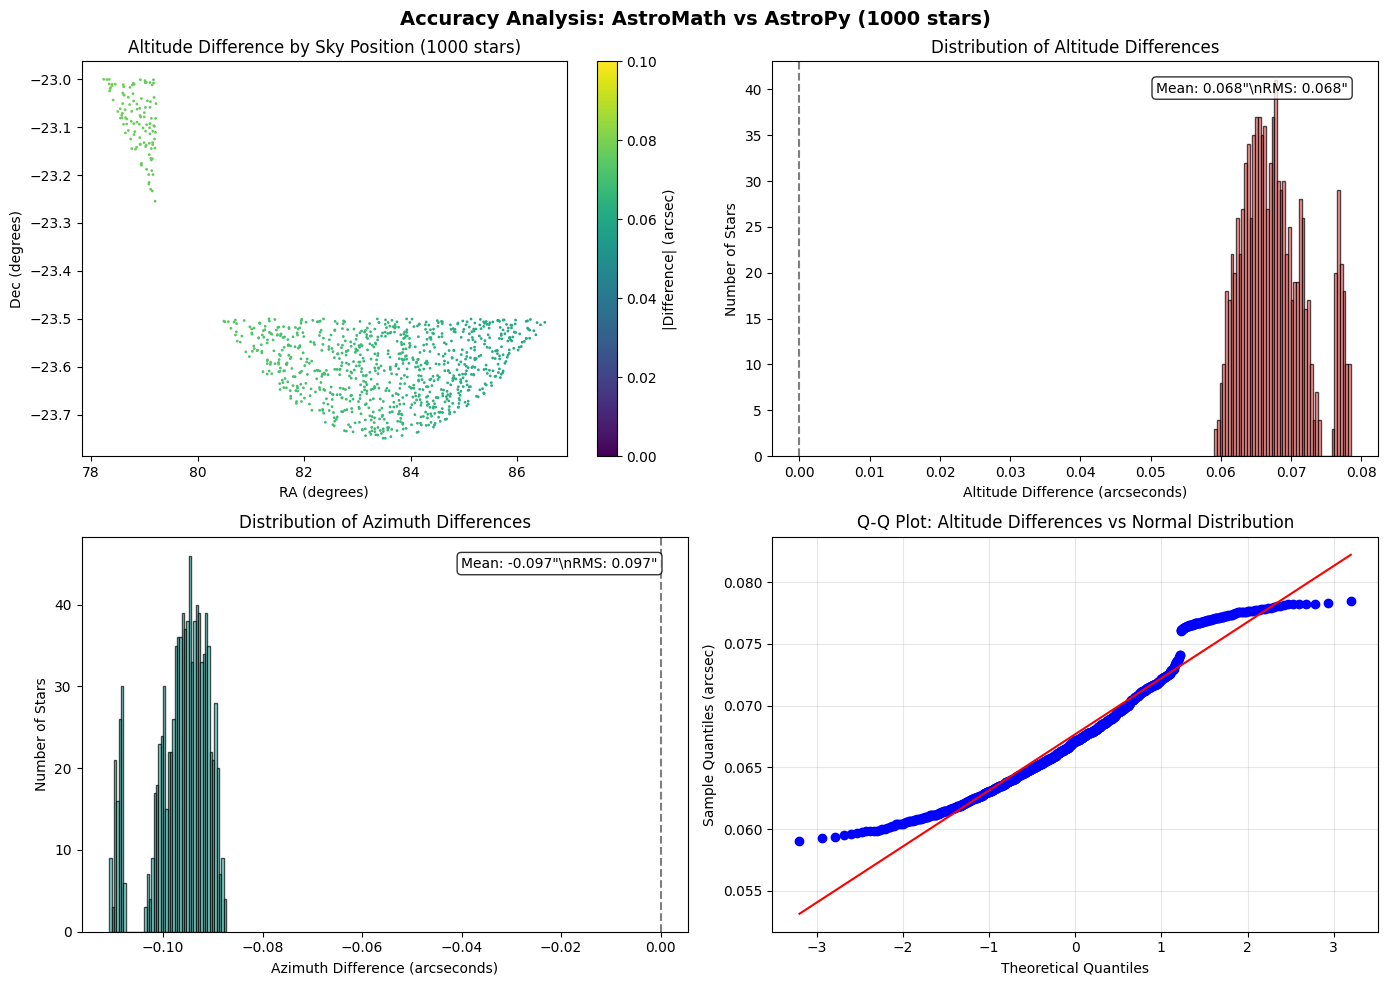


Accuracy Summary (1000 stars):
Altitude - Mean: 0.0677", RMS: 0.0678"
Azimuth  - Mean: -0.0966", RMS: 0.0967"
Maximum absolute differences: Alt=0.0785", Az=0.1108"


In [13]:
# Detailed accuracy analysis on 1000 stars
print("Performing detailed accuracy analysis on 1,000 stars...")

# Get 1000 stars for detailed accuracy analysis
accuracy_sample = star_data[:1000]
accuracy_ra = np.ascontiguousarray(accuracy_sample[:, 0])
accuracy_dec = np.ascontiguousarray(accuracy_sample[:, 1])

# AstroMath conversion
alt_am_1k, az_am_1k = astro_math.batch_ra_dec_to_alt_az(
    accuracy_ra, accuracy_dec, test_time,
    test_location['latitude'], test_location['longitude'], test_location['altitude']
)

# AstroPy conversion
coords_1k = SkyCoord(ra=accuracy_ra*u.deg, dec=accuracy_dec*u.deg)
altaz_1k = coords_1k.transform_to(altaz_frame)
alt_ap_1k = altaz_1k.alt.deg
az_ap_1k = altaz_1k.az.deg

# Calculate differences
alt_diff_1k = (alt_am_1k - alt_ap_1k) * 3600  # Convert to arcseconds
az_diff_1k = (az_am_1k - az_ap_1k) * 3600

# Handle azimuth wrap-around
az_diff_1k = np.where(az_diff_1k > 648000, az_diff_1k - 1296000, az_diff_1k)  # 360*3600 = 1296000
az_diff_1k = np.where(az_diff_1k < -648000, az_diff_1k + 1296000, az_diff_1k)

# Create accuracy visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Scatter plot of differences
scatter = ax1.scatter(accuracy_ra, accuracy_dec, c=np.abs(alt_diff_1k), 
                     s=1, cmap='viridis', vmin=0, vmax=0.1)
ax1.set_xlabel('RA (degrees)')
ax1.set_ylabel('Dec (degrees)')
ax1.set_title('Altitude Difference by Sky Position (1000 stars)')
plt.colorbar(scatter, ax=ax1, label='|Difference| (arcsec)')

# Histogram of altitude differences
ax2.hist(alt_diff_1k, bins=50, alpha=0.7, color='#FF6B6B', edgecolor='black')
ax2.set_xlabel('Altitude Difference (arcseconds)')
ax2.set_ylabel('Number of Stars')
ax2.set_title('Distribution of Altitude Differences')
ax2.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax2.text(0.95, 0.95, f'Mean: {np.mean(alt_diff_1k):.3f}"\\nRMS: {np.sqrt(np.mean(alt_diff_1k**2)):.3f}"',
        transform=ax2.transAxes, ha='right', va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Histogram of azimuth differences
ax3.hist(az_diff_1k, bins=50, alpha=0.7, color='#4ECDC4', edgecolor='black')
ax3.set_xlabel('Azimuth Difference (arcseconds)')
ax3.set_ylabel('Number of Stars')
ax3.set_title('Distribution of Azimuth Differences')
ax3.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax3.text(0.95, 0.95, f'Mean: {np.mean(az_diff_1k):.3f}"\\nRMS: {np.sqrt(np.mean(az_diff_1k**2)):.3f}"',
        transform=ax3.transAxes, ha='right', va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Q-Q plot to check if differences are normally distributed
from scipy import stats
stats.probplot(alt_diff_1k, dist="norm", plot=ax4)
ax4.set_title('Q-Q Plot: Altitude Differences vs Normal Distribution')
ax4.set_xlabel('Theoretical Quantiles')
ax4.set_ylabel('Sample Quantiles (arcsec)')
ax4.grid(True, alpha=0.3)

plt.suptitle('Accuracy Analysis: AstroMath vs AstroPy (1000 stars)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nAccuracy Summary (1000 stars):")
print(f"Altitude - Mean: {np.mean(alt_diff_1k):.4f}\", RMS: {np.sqrt(np.mean(alt_diff_1k**2)):.4f}\"")
print(f"Azimuth  - Mean: {np.mean(az_diff_1k):.4f}\", RMS: {np.sqrt(np.mean(az_diff_1k**2)):.4f}\"")
print(f"Maximum absolute differences: Alt={np.max(np.abs(alt_diff_1k)):.4f}\", Az={np.max(np.abs(az_diff_1k)):.4f}\"")